<a href="https://colab.research.google.com/github/madhavkumar1523/Optical-Character-Recognition/blob/main/OCR_Envision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optical Character Recognition using Convolutional Neural Networks

This notebook contains the code used to load character datasets from the internet, preprocess the data and train a CNN model to predict the character labels. We also take a real world image of handwritten characters to observe how our model fits to real world data. The full project report can be found [here.](https://ieee.nitk.ac.in/virtual-expo)

## References
- [A-Z Handwritten Alphabets in .csv format | Kaggle](https://www.kaggle.com/sachinpatel21/az-handwritten-alphabets-in-csv-format)
- [MNIST digits classification dataset | Keras](https://keras.io/api/datasets/mnist/)
- [Keras Layers API](https://keras.io/api/layers/#layers-api-overview)

In [ ]:
# Importing the MNIST Dataset
from tensorflow.keras.datasets import mnist

# Importing data manipulation and visualisation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Loading the datasets

The MNIST Dataset is simply loaded in using the `load_data` function provided by the Keras dataset.

We use the [Kaggle API](https://github.com/Kaggle/kaggle-api) to download the A-Z Handwritten Alphabets dataset into the Colab storage. In order to use the Kaggle API, an API Key needs to be generated and uploaded to the Colab environment. To create your own API Key, follow the steps mentioned [here.](https://github.com/Kaggle/kaggle-api#api-credentials)

The dataset is downloaded and then loaded into a Pandas DataFrame.

In [ ]:
# Load the MNIST Number dataset
(train_X_mn, train_y_mn), (test_X_mn, test_y_mn) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


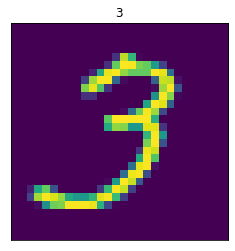

In [ ]:
# Displaying random images from the training dataset
mn_idx = np.random.randint(0, train_X_mn.shape[0])
plt.imshow(train_X_mn[mn_idx])
plt.title(train_y_mn[mn_idx])
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# Kaggle API Key import
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
# Load the dataset from Kaggle
!kaggle datasets download "sachinpatel21/az-handwritten-alphabets-in-csv-format"
!unzip az-handwritten-alphabets-in-csv-format.zip

 97% 180M/185M [00:05<00:00, 39.0MB/s]
100% 185M/185M [00:05<00:00, 32.5MB/s]
Archive:  az-handwritten-alphabets-in-csv-format.zip
  inflating: A_Z Handwritten Data.csv  
  inflating: A_Z Handwritten Data/A_Z Handwritten Data.csv  


In [ ]:
# Load the A-Z Handwritten dataset into a Pandas DataFrame
# This takes time (and RAM usage) because the dataset is 666.53MB in size
_X_az = pd.read_csv('/content/A_Z Handwritten Data.csv')
_X_az.rename(columns={'0':'label'}, inplace=True)

# Split the dataset into the target variable and training data
y_az = _X_az.label.to_numpy()
X_az = _X_az.drop('label', axis=1).to_numpy()

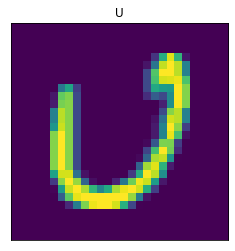

In [ ]:
# Displaying random images from the A-Z Handwritten dataset
az_idx = np.random.randint(0, X_az.shape[0])
plt.imshow(X_az[az_idx].reshape((28,28)))
plt.title(chr(y_az[az_idx] + 65))
plt.xticks([])
plt.yticks([])
plt.show()

# 2. Data Preprocessing

We first split the A-Z Handwritten Alphabets Dataset into train and test sets. The MNIST Digits Dataset is already split into train and test sets.

We then scale our data using the Standard Scaler provided by scikit-learn. In order to scale the data, we first reshape each 28 x 28 image in the MNIST Digits Dataset into a long 784 dimensional vector.

Since we will be compiling the datasets together, we increment the A-Z Handwritten Alphabets Dataset labels by 10. Therefore, labels 0-9 represent the digits 0-9, and labels 10-35 represent the characters A-Z.

We also apply one-hot encoding on the target variable in order to align the target variable with the output of the CNN model.



In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing data
train_X_az, test_X_az, train_y_az, test_y_az = train_test_split(X_az, y_az, test_size = 0.1)

In [ ]:
# Adding 10 to every character label
train_y_az += 10
test_y_az += 10

# Reshaping the MNIST Digits Dataset to a set of 784 dimensional vectors 
train_X_mn = train_X_mn.reshape((train_X_mn.shape[0], 784))
test_X_mn = test_X_mn.reshape((test_X_mn.shape[0], 784))

# Compiling the MNIST Dataset and the A-Z Handwritten Dataset
train_X = np.vstack((train_X_mn, train_X_az))
train_y = np.hstack((train_y_mn, train_y_az))

test_X = np.vstack((test_X_mn, test_X_az))
test_y = np.hstack((test_y_mn, test_y_az))

In [ ]:
from keras.utils.np_utils import to_categorical

# Converting the outputs to a one hot encoding (which will be used to predict the output for the CNN)
train_y_ohc = to_categorical(train_y, num_classes=36, dtype=int)
test_y_ohc = to_categorical(test_y, num_classes=36, dtype=int)

### **Note**

At this point, with all the different variables we have created, the RAM usage starts nearing ~10GB. Further computation cannot be done using the free tier of Colab, because the RAM usage will exceed 12.69GB (total RAM allocated for the free tier). Thus, we save the existing dataset into Google Drive and restart the runtime. This refreshes the RAM usage so that we can execute the remaining cells in the notebook.

In [ ]:
# Save the dataset (including train and test) into a numpy archive (.npz)
np.savez("dataset_unscaled.npz", train_X=train_X, train_y=train_y_ohc, test_X=test_X, test_y=test_y_ohc)

In [ ]:
# Kill the current Python runtime process, which will cause the Colab runtime to restart
import os
os.kill(os.getpid(), 9)

In [ ]:
# Import the necessary libraries after restarting the runtime
# If the runtime is not being restarted, this cell can be skipped
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Reload the data from the saved numpy archive
dataset = np.load("dataset_unscaled.npz")

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaling the data
scaler = StandardScaler()
train_X_sc = scaler.fit_transform(dataset["train_X"])
test_X_sc = scaler.transform(dataset["test_X"])

In [ ]:
# Reshape the data into an array of (28,28,1) images
train_X = train_X_sc.reshape((train_X_sc.shape[0], 28, 28, 1))
test_X = test_X_sc.reshape((test_X_sc.shape[0], 28, 28, 1))

# 3. Creating and Training the CNN Model

We create a simple CNN model using layers provided by Keras. We then train this model on the scaled data using the Adam optimizer.

The training and validation losses and accuracies are visualized using line graphs provided by matplotlib.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

# Defining the model architecture
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(192, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

In [ ]:
# Fitting the model to the training data and validating using testing data
history = model.fit(train_X, dataset['train_y'], epochs=8, batch_size=128, verbose=1, validation_data=(test_X, dataset['test_y']))

Epoch 1/8
3088/3088 [==============================] - 70s 13ms/step - loss: 0.2109 - accuracy: 0.9439 - val_loss: 0.1109 - val_accuracy: 0.9682
Epoch 2/8
3088/3088 [==============================] - 39s 13ms/step - loss: 0.0849 - accuracy: 0.9763 - val_loss: 0.0911 - val_accuracy: 0.9742
Epoch 3/8
3088/3088 [==============================] - 39s 13ms/step - loss: 0.0646 - accuracy: 0.9815 - val_loss: 0.0774 - val_accuracy: 0.9789
Epoch 4/8
3088/3088 [==============================] - 40s 13ms/step - loss: 0.0525 - accuracy: 0.9847 - val_loss: 0.0664 - val_accuracy: 0.9819
Epoch 5/8
3088/3088 [==============================] - 39s 13ms/step - loss: 0.0432 - accuracy: 0.9875 - val_loss: 0.0622 - val_accuracy: 0.9825
Epoch 6/8
3088/3088 [==============================] - 39s 13ms/step - loss: 0.0368 - accuracy: 0.9890 - val_loss: 0.0572 - val_accuracy: 0.9841
Epoch 7/8
3088/3088 [==============================] - 40s 13ms/step - loss: 0.0340 - accuracy: 0.9900 - val_loss: 0.0653 - val_ac

In [ ]:
# Print out the loss and accuracy scores
scores = model.evaluate(test_X, dataset['test_y'], verbose=0)
print('Validation Loss : {:.4f}'.format(scores[0]))
print('Validation Accuracy: {:.4f}'.format(scores[1]))

Validation Loss : 0.0634
Validation Accuracy: 0.9835


<Figure size 432x288 with 0 Axes>

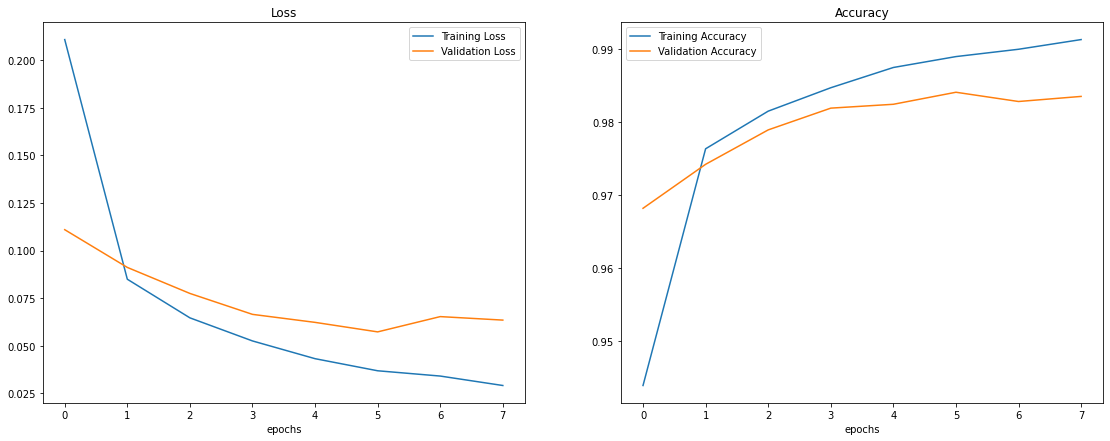

In [ ]:
# Create 2 subplots to plot the loss and accuracy curves
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,7))

# Plot Loss function values over epochs for training and validation sets
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training Loss','Validation Loss'])
ax1.set_title('Loss')
ax1.set_xlabel('epochs')

# Plot accuracy over epochs for training and validation sets
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training Accuracy','Validation Accuracy'])
ax2.set_title('Accuracy')
ax2.set_xlabel('epochs')

fig.show()

# 4. Predicting Characters on Real World Data

We now use image processing to extract the characters from an image of handwritten alphabets. We make use of image processing libraries like OpenCV to find the contours and reshape the character images to the exact dimensions required.

Once we extract the characters, we pass them to the model for it to predict the character label. We finally write the results back on to the image as our final result.

In [ ]:
import cv2
import imutils
from imutils.contours import sort_contours
from google.colab.patches import cv2_imshow

# Load in our image
img = cv2.imread("abc.jpeg")
img = cv2.copyMakeBorder(img, top = 40, bottom=0, left=0, right = 40, borderType = cv2.BORDER_CONSTANT, value=(255,255,255))

# Convert to B/W (single channel)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply blur to reduce noise and smooth out the edges
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detection to find all the edges of the image
edged = cv2.Canny(blurred, 30, 150)

# Find all the contours, retrieve only external contours and store only corner points
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Grab all contours 
cnts = imutils.grab_contours(cnts)
# cnts = sort_contours(cnts, method="left-to-right")[0]

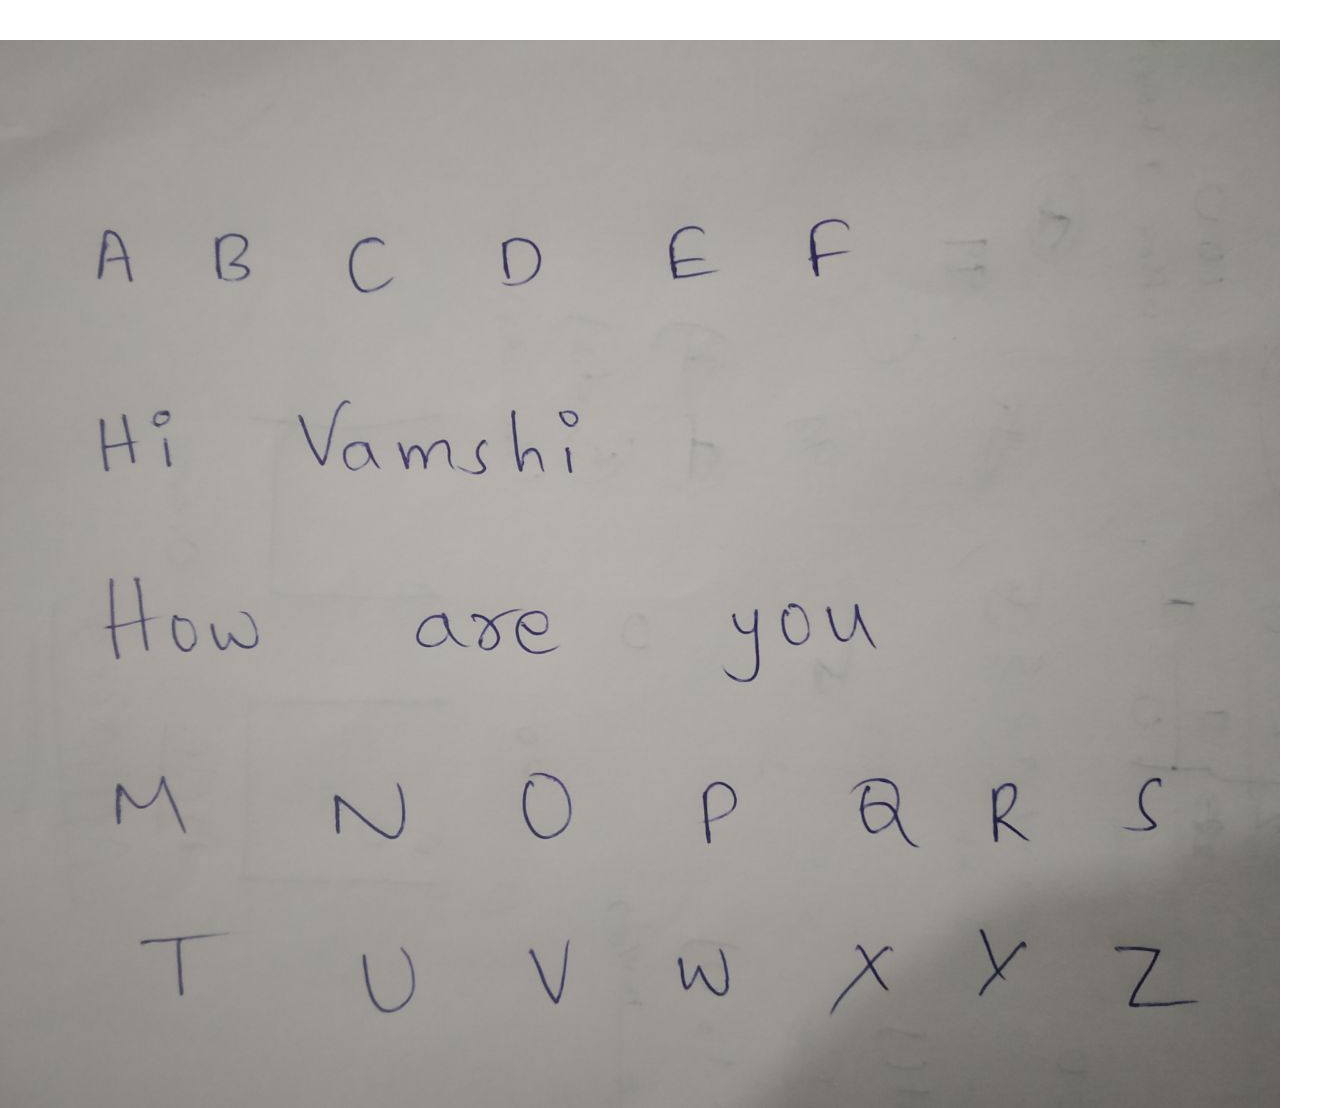

In [ ]:
cv2_imshow(img)

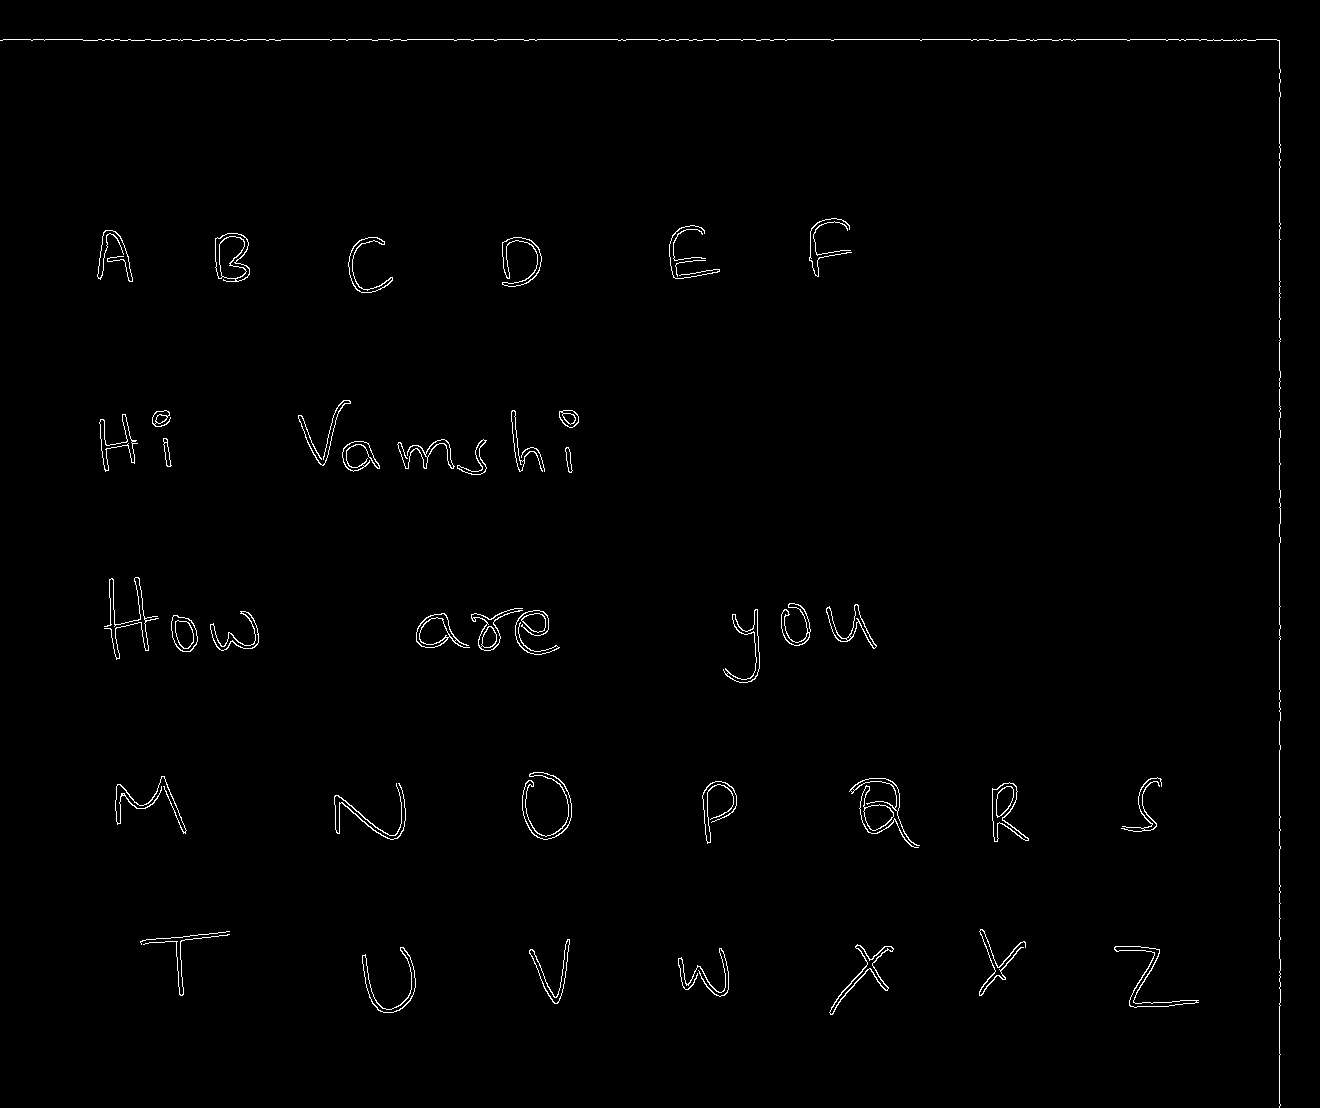

In [ ]:
cv2_imshow(edged)

In [ ]:
chars = []
for c in cnts:
    # Find the bounding rectangle of the contour
    (x ,y, w, h) = cv2.boundingRect(c)

    # Eliminate misinterpreted contours
    if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
        # Extract the Region of Interest
        roi = gray[y:y + h, x:x + w]

        # Since the original images have white background, invert the colors using inverted threshold
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape

        # Resize image wrt one dimension
        if tW > tH:
            thresh = imutils.resize(thresh, width=28)
        else:
            thresh = imutils.resize(thresh, height=28)

        # Fetch new shape
        (tH, tW) = thresh.shape

        # Find the total space needed to fill as border
        dX = int(max(0, 28 - tW) / 2.0)
        dY = int(max(0, 28 - tH) / 2.0)

        # Add a border if the image is smaller than necessary, using a constant black border
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY, left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

        # Resize the images to our requirement
        padded = cv2.resize(padded, (28, 28))
        chars.append((padded, (x,y,w,h)))

In [ ]:
# Separate the boxes and chars into 2 different lists
boxes = [b[1] for b in chars]
test_chars = np.array([c[0] for c in chars], dtype="float32")

# Create a list of labels
labels = list(range(0,10))
for i in range(65, 91):
    labels.append(chr(i))

In [ ]:
# Have the model predict the output of our characters
preds = model.predict(test_chars.reshape((test_chars.shape[0], 28,28,1)), verbose=0)

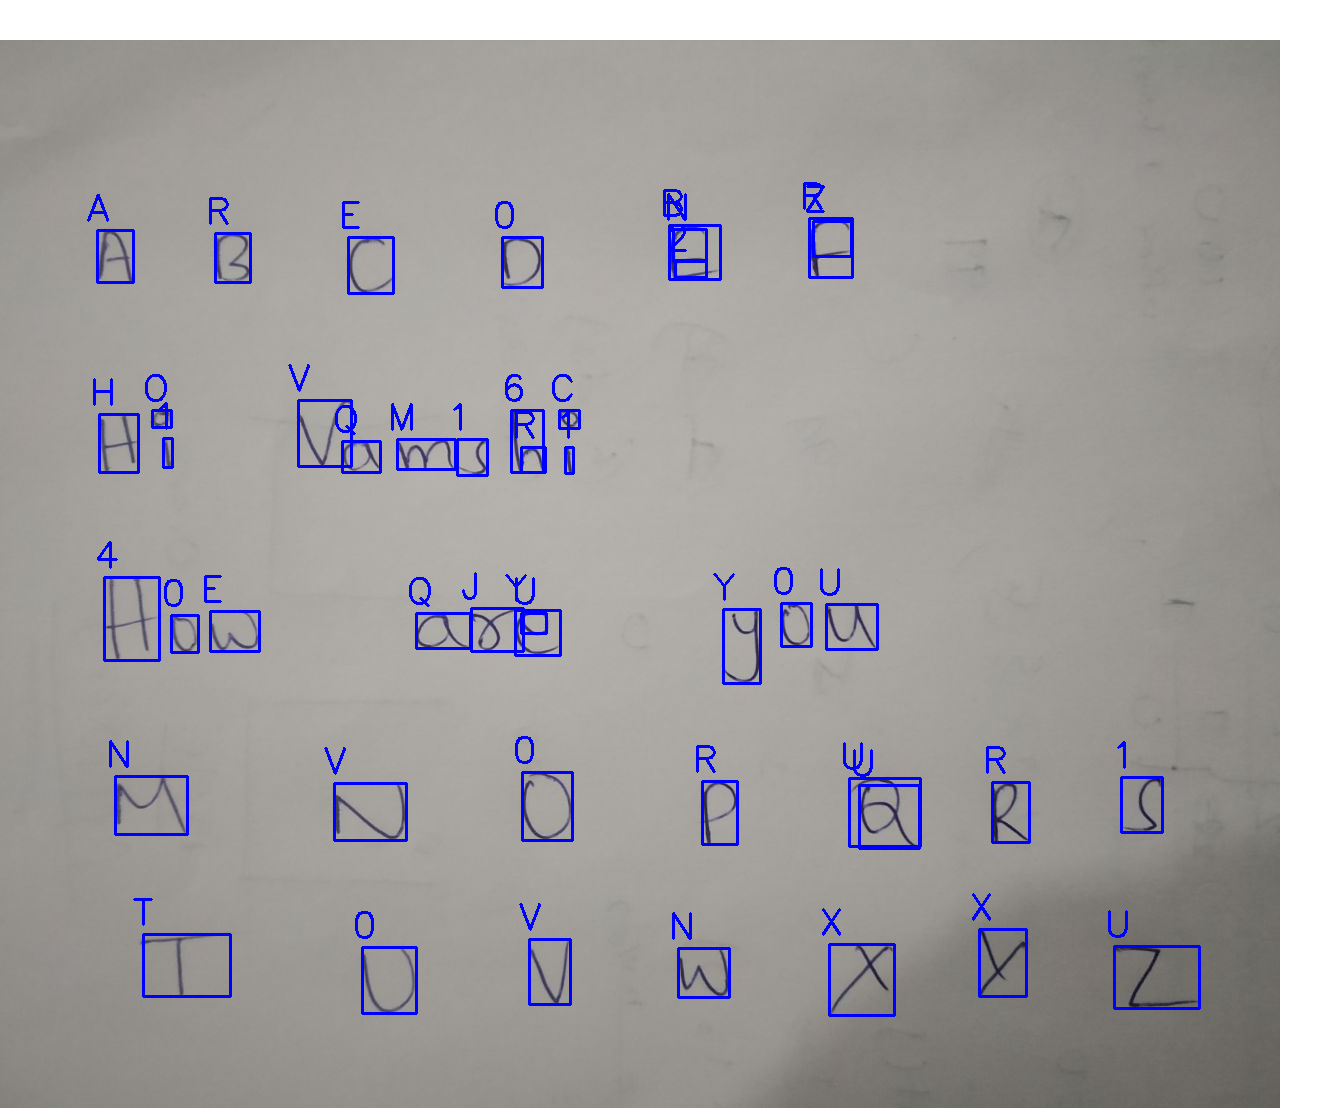

In [ ]:
# Draw the outputs onto the original image
img2 = img.copy()
for (pred, (x,y,w,h)) in zip(preds, boxes):
    i = np.argmax(pred)
    prob = pred[i]
    label = labels[i]
    cv2.rectangle(img2, (x,y), (x+w, y+h), (255,0,0), 2)
    cv2.putText(img2, str(label), (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0), 2)

cv2_imshow(img2)